# 3º Parte: Proyecto de análisis y gestión de recursos aeroportuarios del Aeroparque Jorge Newbery

### Big Data Bang: explosionando las rutas aéreas para predecir un caos en alto vuelo.
---


Grupos de trabajo:
* Joaquin Barrionuevo
* Sebastián Coca
* Sabrina Gonzalez del Campo

### Instalación y actualización de librerías a utilizar en el desarrollo del proyecto

In [ ]:
#@title Instalación de librerías externas
#!pip install -q pingouin
#!pip install calmap
#!pip install july
!pip install geopandas
#!pip install -q folium
!pip install imbalanced-learn

In [ ]:
# Import external libraries
#import pingouin as pg
#import calmap
#import july
import geopandas

import folium  #needed for interactive map
from folium.plugins import HeatMap

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier

#import imblearn
#print(imblearn.__version__)

In [ ]:
#@title Carga de librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import datetime
import warnings

#import missingno as msno
#import pingouin as pg
import plotly.express as px
#from ydata_profiling import ProfileReport
import matplotlib.colors as mcolors

from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier  #arbol de decision
from sklearn import tree #arbol de decision
from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from geopy.distance import geodesic
from tabulate import tabulate
#import matplotlib.dates as mdates


# src: https://github.com/jbagnato/machine-learning/blob/master/Ejercicio_imbalanced_data.ipynb
from pylab import rcParams
from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 10, 6.18 # Golden Mean
LABELS = ["Normal","Retrasado"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

In [ ]:
use_drive = False
if (use_drive):
  from google.colab import drive
  drive.mount('/content/drive')
  # guardado de la DB en el drive
  path = '/content/drive/Shared drives/M08-BigDataBang/'

In [ ]:
# Carga de parámetros
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
#@title Lectura de las DB's: completa y filtrada

fechas = ['Horario_Prog_Arribo', 'Horario_Estimado_Arribo', 'Horario_Actual_Arribo']     # para que lea como datetime
#lectura = ['TD1', 'TD2', 'TD3', 'Aero_encoder', 'Acft_encoder', 'Cin_norm', 'Dia_Semana_norm', 'Cabecera_norm', 'dist_log', 'Pax_estandar', 'Clima']
url1 = 'https://raw.githubusercontent.com/sebascoca/M08-BDB/main/TP2/db-TP2.csv'

url2 = 'https://raw.githubusercontent.com/sabrinagdc/DiploDatos/main/db_sep_v1.csv'

df = pd.read_csv(url1)#, parse_dates = fechas)

df2 = pd.read_csv(url2)

df2.drop(columns='Retraso 1', inplace=True) # ídem TD1

# Los TD's no pasan al modelo, los separamos en otro df

df2_TDs = df2[['TD1', 'TD2', 'TD3']]

df2.drop(columns=['TD1', 'TD2', 'TD3'], inplace=True)

# descartamos el año por sugerencia de Noe, ya que se debe realizar de manera
# genérica y no sirven para predicciones a futuro

df2.drop(columns=['año_2019', 'año_2020', 'año_2021', 'año_2022'], inplace=True)

display(df)
df2

,TD1_estandar,TD2_estandar,TD3_estandar,Retraso1,Retraso2,Retraso3,Aero_encoder,Acft_encoder,Cin_norm,Cabecera_norm,mes_norm,hora_norm,Dia_Semana_norm,dist_log_estandar,Pax_estandar,Clima
0,-0.65,-0.33,0.00,0,0,0,6,13,0.89,1.00,0.00,0.04,0.17,0.16,-0.24,0
1,-0.33,-0.32,0.17,0,0,1,0,4,0.67,1.00,0.00,0.26,0.17,-0.35,-1.44,0
2,-0.14,-0.07,0.00,0,0,0,0,4,0.89,0.00,0.00,0.30,0.17,0.08,0.76,0
3,-0.31,-0.12,-0.04,0,0,0,4,14,0.11,0.00,0.00,0.30,0.17,0.10,-1.59,0
4,-0.26,-0.11,-0.03,0,0,0,4,14,0.22,0.00,0.00,0.30,0.17,-0.91,0.63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125582,-0.04,-0.05,0.03,0,0,0,20,4,1.00,0.00,0.73,0.96,0.67,0.43,1.40,0
125583,0.44,0.22,0.00,0,0,0,13,5,0.33,0.00,0.73,0.96,0.67,0.25,0.70,0
125584,-0.43,-0.23,0.02,0,0,0,20,4,0.78,0.00,0.73,0.96,0.67,-0.35,0.95,0
125585,-0.21,-0.05,-0.07,0,0,0,8,14,0.89,0.00,0.73,1.00,0.67,0.18,1.23,0


,carga,Clima,Retraso1,Retraso2,Retraso3,Acft_encoder,Cin_norm,mes_norm,hora_norm,Dia_Semana_0,Dia_Semana_1,Dia_Semana_2,Dia_Semana_3,Dia_Semana_4,Dia_Semana_5,Dia_Semana_6,Cabecera_13.0,Cabecera_31.0,AeroA_4M,AeroA_A0,AeroA_AJ,AeroA_AR,AeroA_AU,AeroA_DN,AeroA_FO,AeroA_FQ,AeroA_G3,AeroA_H2,AeroA_JA,AeroA_LA,AeroA_OTHER,AeroA_OY,AeroA_WJ,AeroA_Z7,AeroA_ZP,dist_log_estandar,TD1_estandar,TD2_estandar,TD3_estandar
0,0.55,0,0,0,0,9,0.22,0.55,0.39,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.25,-0.23,-0.16,0.05
1,0.38,0,0,0,0,9,0.33,0.64,0.91,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.25,-0.51,-0.28,0.04
2,0.45,0,0,0,0,9,0.22,0.45,0.74,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.09,-0.29,-0.24,0.12
3,1.00,0,0,0,0,4,0.33,0.09,0.39,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.25,0.07,-0.04,0.08
4,1.00,1,0,0,0,4,0.11,0.18,0.39,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.25,-0.06,-0.00,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92137,0.00,0,1,1,0,13,0.00,0.73,0.04,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.06,1.49,0.70,-0.00
92138,1.00,0,0,0,0,13,0.22,0.73,0.87,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.06,-0.23,-0.11,-0.00
92139,0.00,0,1,1,0,13,0.00,0.09,0.87,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1.77,0.86,0.40,-0.00
92140,0.81,0,1,1,0,11,0.78,0.64,0.61,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.80,1.16,0.54,-0.00


### Análisis de las DB's por desbalanceo

In [ ]:
ret = ['Retraso1', 'Retraso2', 'Retraso3']
tds = ['TD1_estandar', 'TD2_estandar', 'TD3_estandar']

print("Análisis de ambas bases de datos (DB's): COMPLETA y FILTRADA")
print('\nFormato de la DB COMPLETA:', df.shape,
      '\nFormato de la DB FILTRADA:', df2.shape,
      '\n')
print('Se observa que nuestras variables objetivos están **desbalanceadas**')

balance=[]
for i, r in enumerate(ret):
  estdd = pd.value_counts(df[r], sort=True)
  estdd2 = pd.value_counts(df2[r], sort=True)
  balance.append([r, estdd[0], estdd[1],estdd[1]/df.shape[0]*100, '',
                  estdd2[0], estdd2[1], estdd2[1]/df2.shape[0]*100])


print('\n\t\tBASE COMPLETA \t\t\t\t\t BASE FILTRADA')
encabezados = ['Sin retraso', 'Retrasado', '%', '', 'Sin retraso', 'Retrasado', '%']
print(tabulate(balance, headers=encabezados, tablefmt="fancy_grid"))

Análisis de ambas bases de datos (DB's): COMPLETA y FILTRADA

Formato de la DB COMPLETA: (125587, 16) 
Formato de la DB FILTRADA: (92142, 39) 

Se observa que nuestras variables objetivos están **desbalanceadas**

		BASE COMPLETA 					 BASE FILTRADA
╒══════════╤═══════════════╤═════════════╤═════════╤════╤═══════════════╤═════════════╤═════════╕
│          │   Sin retraso │   Retrasado │       % │    │   Sin retraso │   Retrasado │       % │
╞══════════╪═══════════════╪═════════════╪═════════╪════╪═══════════════╪═════════════╪═════════╡
│ Retraso1 │        115308 │       10279 │ 8.18476 │    │         85085 │        7057 │ 7.65883 │
├──────────┼───────────────┼─────────────┼─────────┼────┼───────────────┼─────────────┼─────────┤
│ Retraso2 │        114224 │       11363 │ 9.04791 │    │         84038 │        8104 │ 8.79512 │
├──────────┼───────────────┼─────────────┼─────────┼────┼───────────────┼─────────────┼─────────┤
│ Retraso3 │        120729 │        4858 │ 3.86823 │    │       

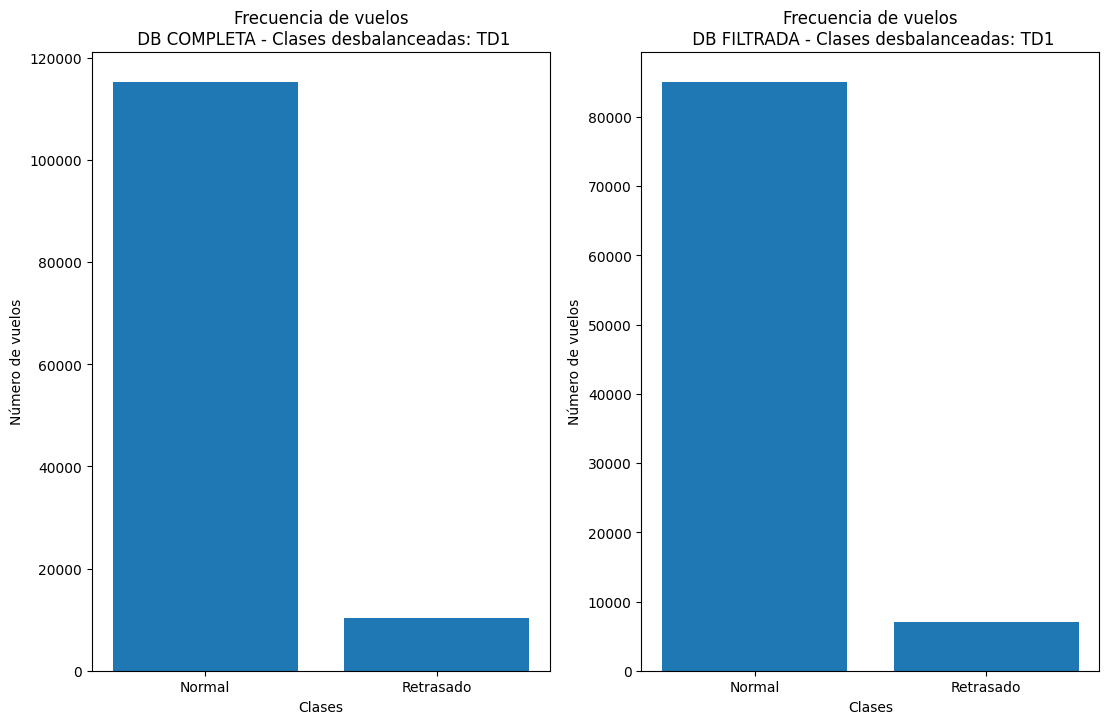

In [ ]:
# Se realiza el análisis con el TD1

# ============ para el análisis =============
# Se modifican estas variables para todo el análisis posterior
id = '1'
retraso = 'Retraso'+id
demora = 'TD'+id
# ===========================================

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13, 8.03), sharey=False)
#plt.title(f"Frecuencia del número de vuelos COMPLETOS / FILTRADOS - Clases desbalanceadas: {demora}")

count_classes = pd.value_counts(df[retraso], sort = True)

ax1.bar( LABELS, count_classes)
ax1.set_xlabel('Clases')
ax1.set_ylabel('Número de vuelos')
#ax1.yaxis.tick_left()
ax1.set_title(f"Frecuencia de vuelos\n DB COMPLETA - Clases desbalanceadas: {demora}")

#count_classes.plot(kind = 'bar', rot=0)
#plt.xticks(range(2), LABELS)
#plt.title(f"Frecuencia del número de vuelos COMPLETOS / FILTRADOS - Clases desbalanceadas: {demora}")
#plt.xlabel("Clase")
#plt.ylabel("Número de vuelos")
#plt.show()

count_classes2 = pd.value_counts(df2[retraso], sort = True)
ax2.bar( LABELS, count_classes2)
ax2.set_xlabel('Clases')
ax2.set_ylabel('Número de vuelos')
ax2.set_title(f"Frecuencia de vuelos\n DB FILTRADA - Clases desbalanceadas: {demora}")
#count_classes2.plot(kind = 'bar', rot=0)
#plt.xticks(range(2), LABELS)
#plt.title(f"Frecuencia del número de vuelos FILTRADOS - Clases desbalanceadas: {demora}")
#plt.xlabel("Clase")
#plt.ylabel("Número de vuelos")
plt.show()

Text(0.5, 1.0, 'Frecuencia de vuelos\n DB COMPLETA - Clases desbalanceadas: TD1')

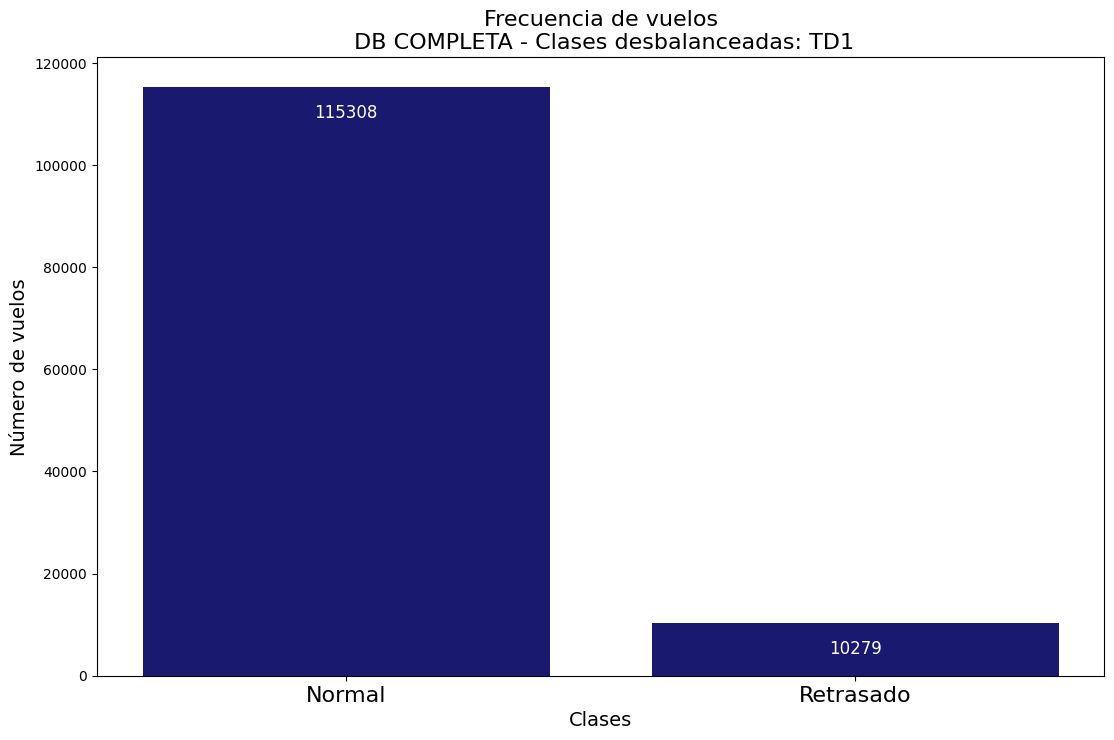

In [ ]:
#@title PRESENTACIÓN DB completa

fig, ax1 = plt.subplots(1,1, figsize=(13, 8.03), sharey=False)

rect = ax1.bar( LABELS, count_classes, color='midnightblue')
ax1.set_xlabel('Clases', fontsize=14)
ax1.set_ylabel('Número de vuelos', fontsize=14)
#ax1.yaxis.tick_left()
ax1.bar_label(rect, padding=-25, color='white', fontsize=12)
ax1.set_xticks([0, 1], LABELS, fontsize=16)
ax1.set_title(f"Frecuencia de vuelos\n DB COMPLETA - Clases desbalanceadas: {demora}", fontsize=16)

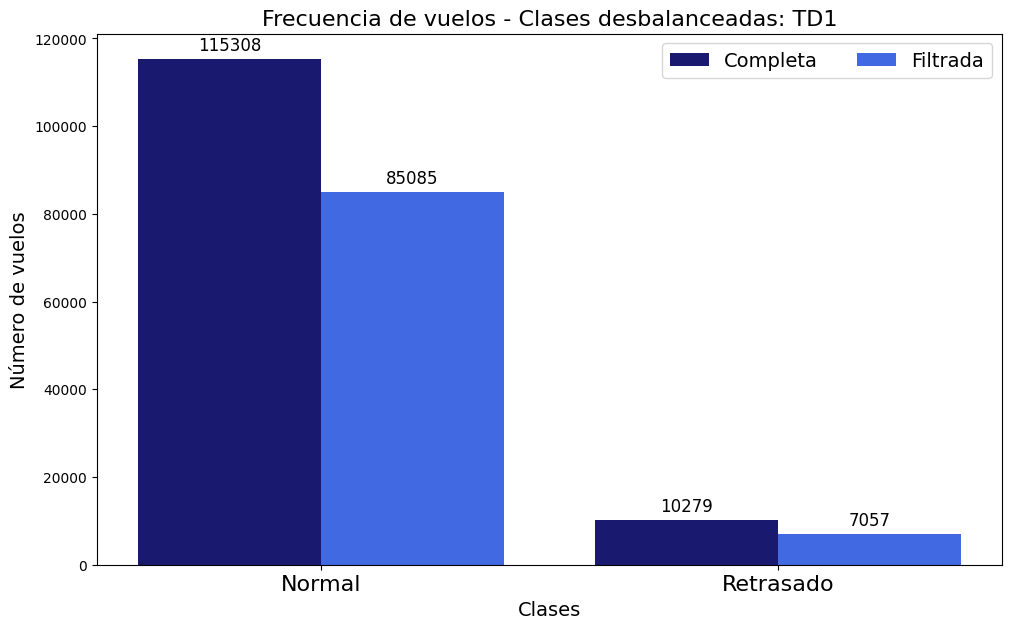

In [ ]:
#@title PRESENTACIÓN: Bases de datos

dbs = {
    'Completa': (count_classes[0], count_classes[1]),
    'Filtrada': ((count_classes2[0], count_classes2[1]))
}

x = np.arange(len(count_classes))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in dbs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color= ('midnightblue' if(attribute == 'Completa') else 'royalblue') )
    ax.bar_label(rects, padding=3, fontsize=12)
    multiplier += 1


ax.set_title(f"Frecuencia de vuelos - Clases desbalanceadas: {demora}", fontsize=16)
#plt.bar( LABELS, count_classes)
ax.set_xticks(x + width/2, LABELS, fontsize=16)
ax.set_xlabel('Clases', fontsize=14)
ax.set_ylabel('Número de vuelos', fontsize=14)
ax.legend(loc='upper right', ncols=3, fontsize=14)

En ambas bases de datos se observa el desbalance de los datos. Por tal motivo va a ser necesario tratar los datos porque sino los modelos no van a ser capaces de predecir correctamente.

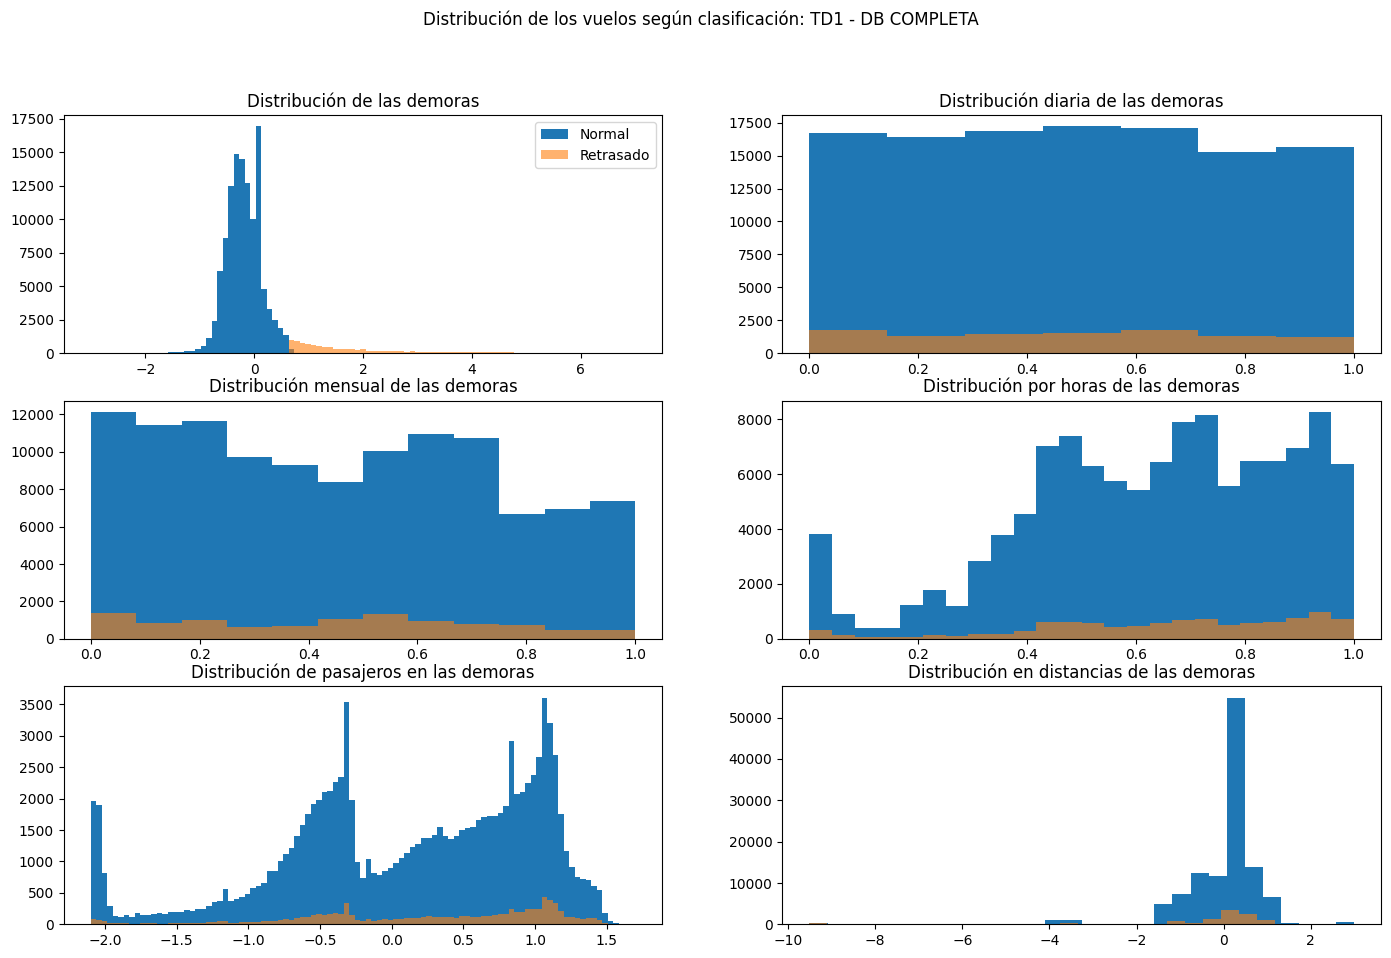

In [ ]:
#@title Análisis de la DB según su clasificación - COMPLETA
crdf = df[df[retraso] == 1 ] # con retraso
srdf = df[df[retraso] == 0 ] # sin retraso


fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, figsize=(17, 10.51), sharey=False)
fig.suptitle(f'Distribución de los vuelos según clasificación: {demora} - DB COMPLETA')#, fontsize=14)

# 1,1
td_est = demora+'_estandar'
bins = np.linspace(-3, 7, 100)
#bins = 300
ax1.hist(srdf[td_est], bins, alpha=1, label='Normal')
ax1.hist(crdf[td_est], bins, alpha=0.6, label='Retrasado')
ax1.legend(loc='upper right')
ax1.set_title("Distribución de las demoras")
#ax1.xlabel("Demora (min)")
#ax1.ylabel("Cantidad de vuelos");

# 1,2
bins = 7
ax2.hist(srdf.Dia_Semana_norm, bins, alpha=1, label='Normal')
ax2.hist(crdf.Dia_Semana_norm, bins, alpha=0.6, label='Retrasado')
ax2.set_title("Distribución diaria de las demoras")
#ax2.legend(loc='upper right')

# 2,1
bins = 12
ax3.hist(srdf.mes_norm, bins, alpha=1, label='Normal')
ax3.hist(crdf.mes_norm, bins, alpha=0.6, label='Retrasado')
#ax3.legend(loc='upper right')
ax3.set_title("Distribución mensual de las demoras")
#ax2.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
#ax2.ylabel("Cantidad de vuelos");
#plt.hist((df.Time/(60*60)),bins)

# 2,2
bins = 24
ax4.hist(srdf.hora_norm, bins, alpha=1, label='Normal')
ax4.hist(crdf.hora_norm, bins, alpha=0.6, label='Retrasado')
ax4.set_title("Distribución por horas de las demoras")
#ax4.legend(loc='upper right')

# 3,1
bins = np.linspace(-2.1, 1.7, 100)
ax5.hist(srdf.Pax_estandar, bins, alpha=1, label='Normal')
ax5.hist(crdf.Pax_estandar, bins, alpha=0.6, label='Retrasado')
ax5.set_title("Distribución de pasajeros en las demoras")

# 3,2
bins = 30#np.linspace(-2.3, 1.7, 100)
ax6.hist(srdf.dist_log_estandar, bins, alpha=1, label='Normal')
ax6.hist(crdf.dist_log_estandar, bins, alpha=0.6, label='Retrasado')
ax6.set_title("Distribución en distancias de las demoras")

plt.show()

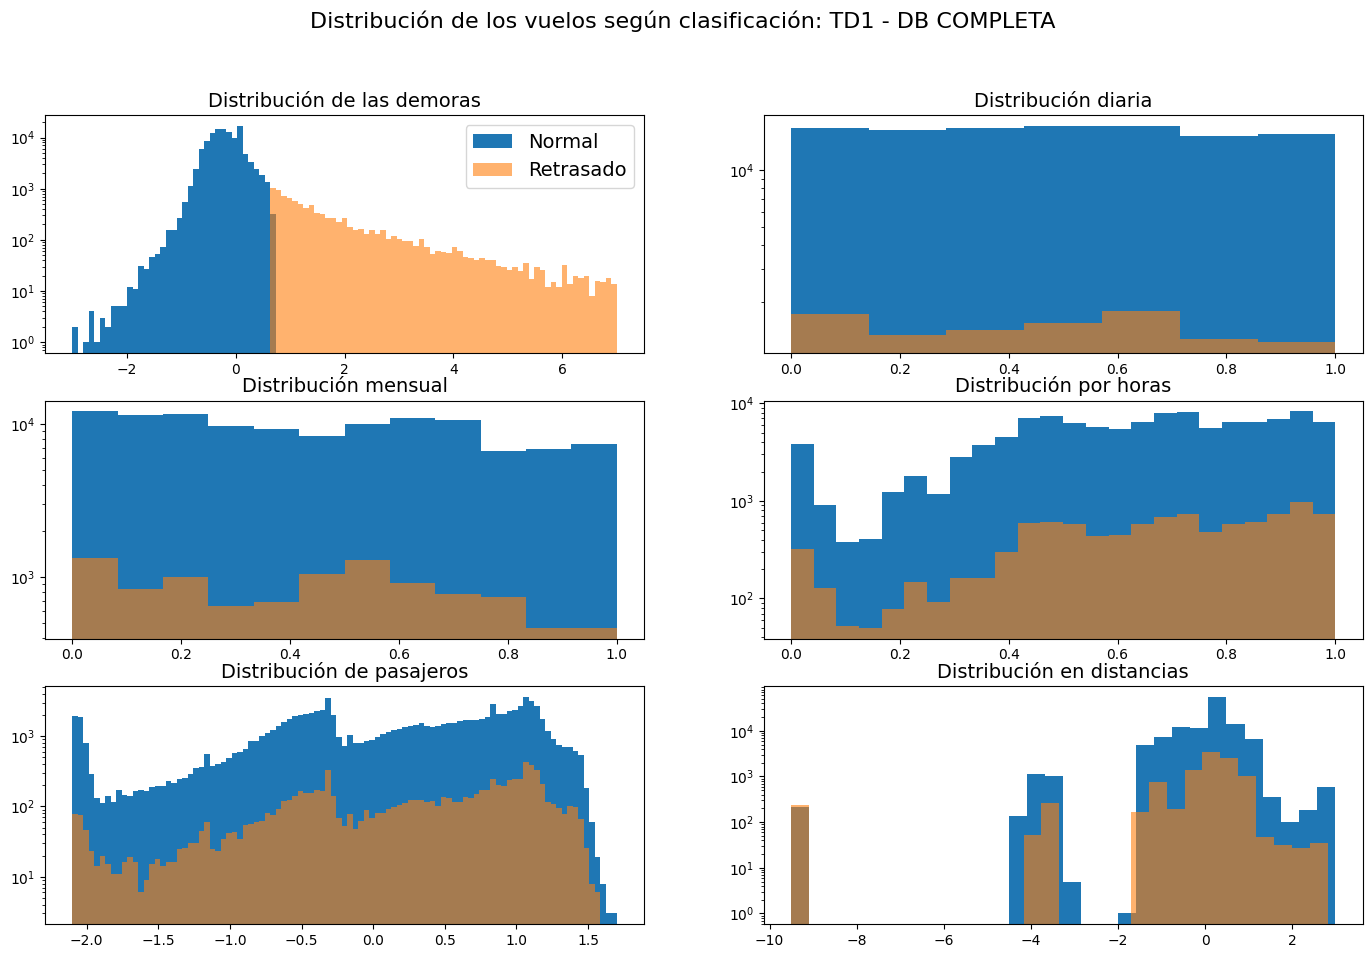

In [ ]:
#@title PRESENTACIÓN: Análisis de la DB según su clasificación - COMPLETA

fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, figsize=(17, 10.51), sharey=False)

#logscale
log = True

# 1,1
bins = np.linspace(-3, 7, 100)
#bins = 300
ax1.hist(srdf[td_est], bins, alpha=1, label='Normal', log=log)
ax1.hist(crdf[td_est], bins, alpha=0.6, label='Retrasado')
ax1.set_title("Distribución de las demoras", fontsize=14)
#ax1.xlabel("Demora (min)")
#ax1.ylabel("Cantidad de vuelos");
ax1.legend(loc='upper right', fontsize=14, ncols=1)


# 1,2
bins = 7
ax2.hist(srdf.Dia_Semana_norm, bins, alpha=1, label='Normal', log=log)
ax2.hist(crdf.Dia_Semana_norm, bins, alpha=0.6, label='Retrasado')
ax2.set_title("Distribución diaria", fontsize=14)
#ax2.legend(loc='upper right')

# 2,1
bins = 12
ax3.hist(srdf.mes_norm, bins, alpha=1, label='Normal', log=log)
ax3.hist(crdf.mes_norm, bins, alpha=0.6, label='Retrasado')
#ax3.legend(loc='upper right')
ax3.set_title("Distribución mensual", fontsize=14)
#ax2.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
#ax2.ylabel("Cantidad de vuelos");
#plt.hist((df.Time/(60*60)),bins)

# 2,2
bins = 24
ax4.hist(srdf.hora_norm, bins, alpha=1, label='Normal', log=log)
ax4.hist(crdf.hora_norm, bins, alpha=0.6, label='Retrasado')
ax4.set_title("Distribución por horas", fontsize=14)
#ax4.legend(loc='upper right')

# 3,1
bins = np.linspace(-2.1, 1.7, 100)
ax5.hist(srdf.Pax_estandar, bins, alpha=1, label='Normal', log=log)
ax5.hist(crdf.Pax_estandar, bins, alpha=0.6, label='Retrasado')
ax5.set_title("Distribución de pasajeros", fontsize=14)

# 3,2
bins = 30#np.linspace(-2.3, 1.7, 100)
ax6.hist(srdf.dist_log_estandar, bins, alpha=1, label='Normal', log=log)
ax6.hist(crdf.dist_log_estandar, bins, alpha=0.6, label='Retrasado')
ax6.set_title("Distribución en distancias", fontsize=14)


fig.suptitle(f'Distribución de los vuelos según clasificación: {demora} - DB COMPLETA', fontsize=16)

plt.show()

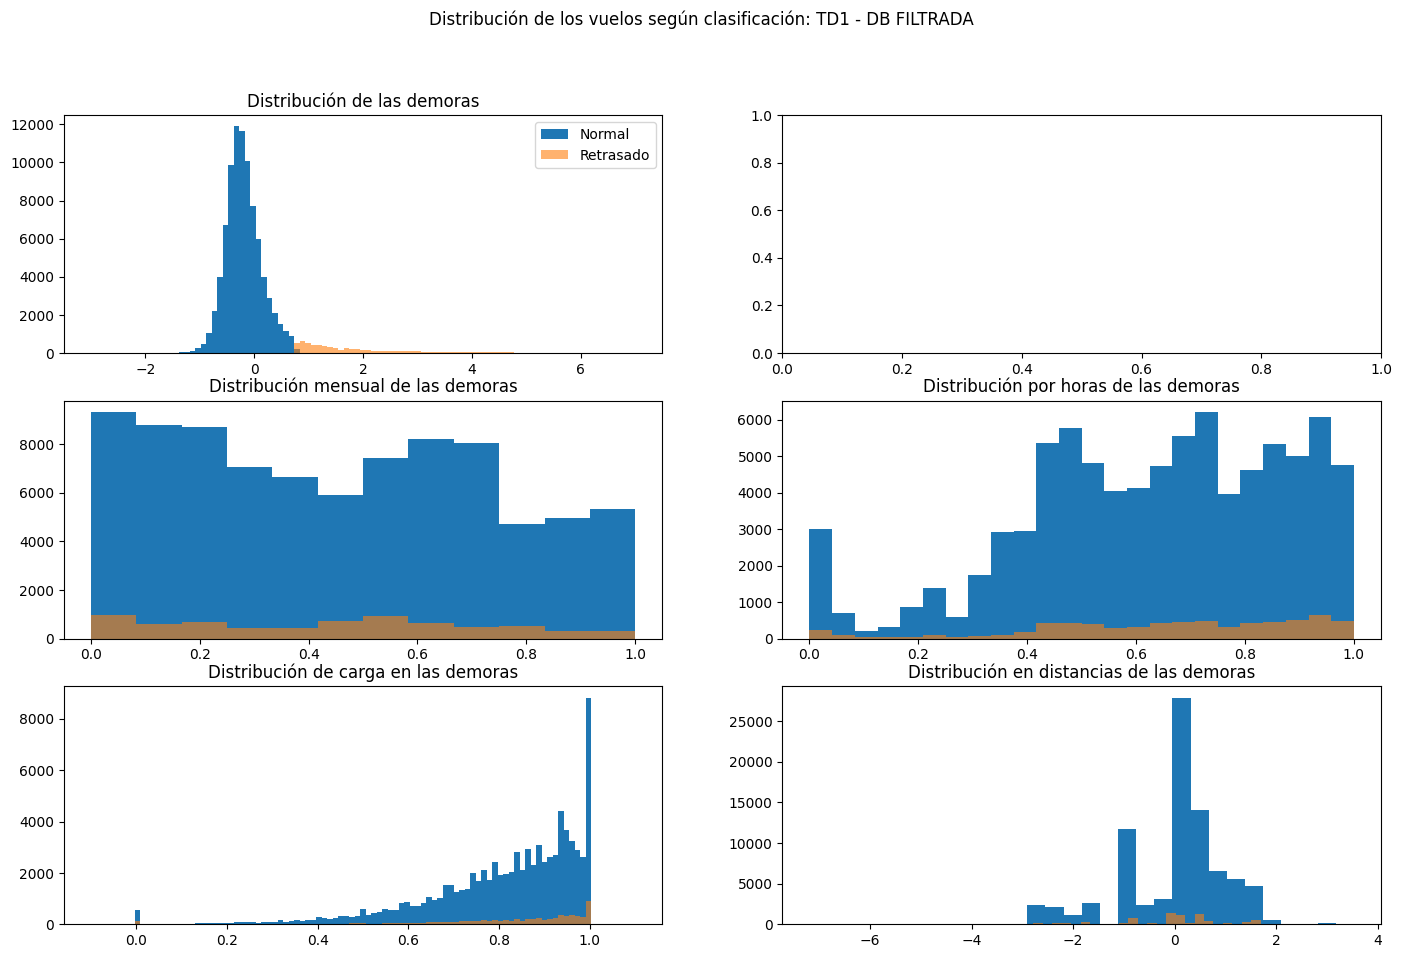

In [ ]:
#@title Análisis de la DB según su clasificación - FILTRADA
crdf2 = df2[df2[retraso] == 1 ] # con retraso
srdf2 = df2[df2[retraso] == 0 ] # sin retraso


fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, figsize=(17, 10.51), sharey=False)
fig.suptitle(f'Distribución de los vuelos según clasificación: {demora} - DB FILTRADA')#, fontsize=14)

# 1,1
td_est = demora+'_estandar'
bins = np.linspace(-3, 7, 100)
#bins = 300
ax1.hist(srdf2[td_est], bins, alpha=1, label='Normal')
ax1.hist(crdf2[td_est], bins, alpha=0.6, label='Retrasado')
ax1.legend(loc='upper right')
ax1.set_title("Distribución de las demoras")
#ax1.xlabel("Demora (min)")
#ax1.ylabel("Cantidad de vuelos");

#print(srdf2['Cabecera_13.0'], crdf2['Cabecera_13.0'] )
## 1,2
#bins = 2
#ax2.bar('Cabecera 13', srdf2['Cabecera_13.0'], height=bins, alpha=1, label='Normal')
#ax2.bar(crdf2['Cabecera_13.0'], height=bins, alpha=0.6, label='Retrasado')
#ax2.bar(srdf2['Cabecera_31.0'], height=bins, alpha=1, label='Normal')
#ax2.bar(crdf2['Cabecera_31.0'], height=bins, alpha=0.6, label='Retrasado')
#ax2.set_title("Distribución por cabeceras de las demoras")
#ax2.legend(loc='upper right')

# 2,1
bins = 12
ax3.hist(srdf2.mes_norm, bins, alpha=1, label='Normal')
ax3.hist(crdf2.mes_norm, bins, alpha=0.6, label='Retrasado')
#ax3.legend(loc='upper right')
ax3.set_title("Distribución mensual de las demoras")
#ax2.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
#ax2.ylabel("Cantidad de vuelos");
#plt.hist((df.Time/(60*60)),bins)

# 2,2
bins = 24
ax4.hist(srdf2.hora_norm, bins, alpha=1, label='Normal')
ax4.hist(crdf2.hora_norm, bins, alpha=0.6, label='Retrasado')
ax4.set_title("Distribución por horas de las demoras")
#ax4.legend(loc='upper right')

# 3,1
bins = np.linspace(-0.1, 1.1, 100)
ax5.hist(srdf2.carga, bins, alpha=1, label='Normal')
ax5.hist(crdf2.carga, bins, alpha=0.6, label='Retrasado')
ax5.set_title("Distribución de carga en las demoras")

# 3,2
bins = 30#np.linspace(-2.3, 1.7, 100)
ax6.hist(srdf2.dist_log_estandar, bins, alpha=1, label='Normal')
ax6.hist(crdf2.dist_log_estandar, bins, alpha=0.6, label='Retrasado')
ax6.set_title("Distribución en distancias de las demoras")

plt.show()

## Clasificación con aprendizaje supervisado

Primero se clasifica y luego se estima la demora

### Análisis de la  DB COMPLETA

In [ ]:
# target -> retraso (definido arriba)

# ======================
# Parámetros fijos
rs = 19 # random_state

perc_div = 0.7
# ======================

col2a1 = ['Acft_encoder', 'mes_norm', 'hora_norm', 'Dia_Semana_norm', 'dist_log_estandar', 'Pax_estandar', 'Clima']#, 'Cin_norm', 'Cabecera_norm', 'Aero_encoder', ]

# Se analiza después
#col2a2 = ['Acft_encoder', 'Dia_Semana_0', 'Dia_Semana_1', 'Dia_Semana_2', 'Dia_Semana_3', 'Dia_Semana_4', 'Dia_Semana_5', 'Dia_Semana_6', 'dist_log_estandar', 'Clima', 'mes_norm', 'hora_norm', 'carga']

y = df[retraso]

tirar = ret + tds
#X = df2.drop(columns=tirar)
X = df[col2a1]
# dividimos el set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=perc_div, random_state=rs)
y_train.value_counts(), y_test.value_counts()

(0    80655
 1     7255
 Name: Retraso1, dtype: int64,
 0    34653
 1     3024
 Name: Retraso1, dtype: int64)

In [ ]:
#@title Funciones para los modelos y gráficos

# definimos modelo base
def run_model_base(xtrain, xtest, ytrain, ytest):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=rs,solver="newton-cg")
    clf_base.fit(xtrain, ytrain)
    return clf_base

# con penalización class_weight='balanced'
def run_model_balanced(xtrain, xtest, ytrain, ytest):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=rs,solver="newton-cg",class_weight="balanced")
    clf.fit(xtrain, ytrain)
    return clf

# modelo general
def run_model(xtrain, xtest, ytrain, ytest, metodo, bul, *args):
    """
    Pasamos los datos de train y test, el método y bul.
    bul: True -> devuelve Confusion Matrix del test
         False -> devuelve Confusion Matrix del train
    """
    modelo = metodo.fit(xtrain, ytrain)
    if(bul):
      pred_y = modelo.predict(xtest)
      return  mostrar_resultados(ytest, pred_y)
    else:
      pred_y = modelo.predict(xtrain)
      return  mostrar_resultados(ytrain, pred_y)
    #return metodo


# Clases antes y después de over/sub-sampleos
def sampleos(y, yres):
  print ("Distribution of class labels before resampling {}".format(Counter(y)),
         "\nDistribution of class labels after resampling {}".format(Counter(yres))
  )

# definimos función para mostrar los resultados
def mostrar_resultados(ytest, predy):
    conf_matrix = confusion_matrix(ytest, predy)
    plt.figure(figsize=(10, 6.18))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Blues_r');
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(ytest, predy))

def correr_modelos(X_train, X_test, y_train, y_test, modelo, trained_models):
    for name, clf in modelo.items():
      print(f"---o---o---o---o---o---o---o---o---o---o---o---o---\nTraining ### {name} ###")
      clf.fit(X_train, y_train)
      train_predictions = clf.predict(X_train)
      test_predictions = clf.predict(X_test)

      print("Report train")
      print(classification_report(y_train, train_predictions))

      print("Report test =============")
      print(classification_report(y_test, test_predictions))

      trained_models.append(clf)
      print("")

#### Modelos a trabajar



In [ ]:
# modelos por default
models_default =  {
  'Arbol de decisión': DecisionTreeClassifier(random_state=rs),
  'Random Forest': RandomForestClassifier(random_state=rs),
  'Regresión Logística': LogisticRegression(random_state=rs),
  'Perceptrón multicapa': MLPClassifier(random_state=rs),
  'XGBoost': XGBClassifier(random_state=rs),
  'Naive Bayes': GaussianNB(),
  'SVM': LinearSVC(random_state=rs),
}

In [ ]:
# modelos mejorados
lr = LogisticRegression(C=1.0, penalty='l2', random_state=rs, solver="newton-cg")
lrp = LogisticRegression(C=1.0, penalty='l2', random_state=rs, solver="newton-cg", class_weight="balanced")
knn = KNeighborsClassifier(n_neighbors=5)
dtc = DecisionTreeClassifier(random_state=rs, criterion='entropy')
rfc = RandomForestClassifier(n_estimators=100, random_state=rs)
mlpc = MLPClassifier(random_state=rs)
xgbc = XGBClassifier(random_state=rs)
gnb = GaussianNB()
lsvc = LinearSVC(random_state=rs)
bbc = BalancedBaggingClassifier(estimator=rfc,
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=rs)

models =  {
  'Regresión Logística': lr,
  'Regresión Logística c/penalización': lrp,
  'Arbol de decisión': dtc,
  'Random Forest': rfc,
  'KNN': knn,
  'Perceptrón multicapa': mlpc,
  'XGBoost': xgbc,
  'Naive Bayes': gnb,
  'SVM': lsvc,
  'Balanced Bagging Classifier': bbc,
}

#### Análisis sin balanceo

Se analizan algunos modelos a modo de ejemplo y se corre para todos los models_default

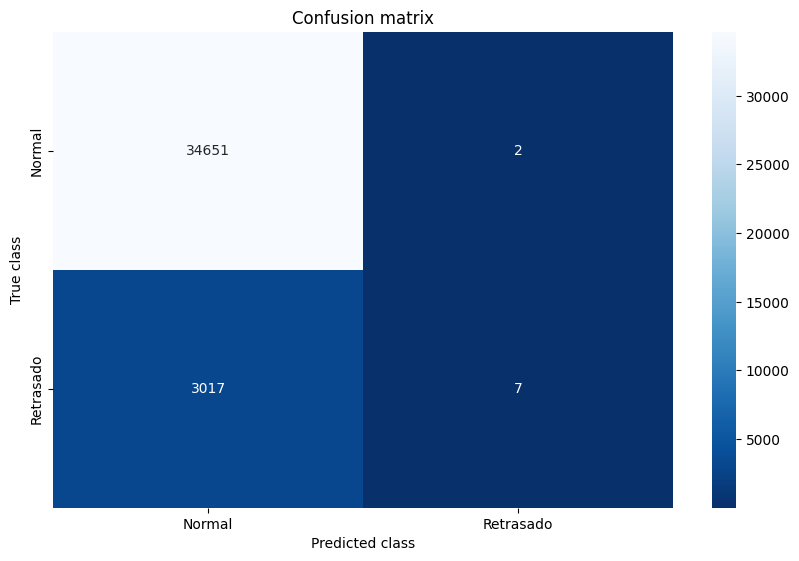

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     34653
           1       0.78      0.00      0.00      3024

    accuracy                           0.92     37677
   macro avg       0.85      0.50      0.48     37677
weighted avg       0.91      0.92      0.88     37677



In [ ]:
#@title Regresión logística
#lr = LogisticRegression(C=1.0, penalty='l2', random_state=rs, solver="newton-cg")
run_model(X_train, X_test, y_train, y_test, lr, True)


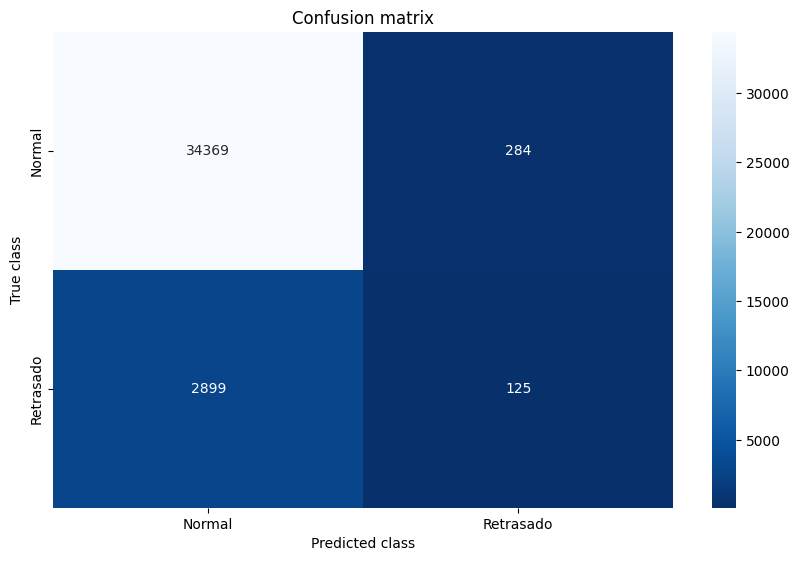

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     34653
           1       0.31      0.04      0.07      3024

    accuracy                           0.92     37677
   macro avg       0.61      0.52      0.51     37677
weighted avg       0.87      0.92      0.88     37677



In [ ]:
#@title KNN

knn2 = KNeighborsClassifier(n_neighbors=2)
run_model(X_train, X_test, y_train, y_test, knn2, True)


Que metrica es mas apropiada para nuestros datos:

La precisión mide la proporción de predicciones correctas respecto al total de predicciones, esta puede ser engañosa si tengemos datos desbalanceados, nos podría dar un valor alto de accuarcy simplemente prediciendo correctamente la clase mayoritaria.

El recall mide la capacidad del modelo para identificar correctamente los positivos (clase minoritaria). Es especialmente útil en problemas de desequilibrio de clases, ya que se centra en detectar la clase minoritaria. Un valor alto de recall indica que el modelo puede identificar la mayoría de los casos positivos.

El f1-score combina estas dos metricas y devuelve una sola.

Por lo tanto observar el recall y el f1-score es una buena elección para nuestros datos, ya que estos estan desbalanceados y tienen importancia detectar los casos positivos.



In [ ]:
#@title corrida models_default

## para no cargar las salidas
#from warnings import simplefilter
#simplefilter("ignore")

trained_modelsD = []

correr_modelos(X_train, X_test, y_train, y_test, models_default, trained_modelsD)

---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Arbol de decisión ###
Report train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80655
           1       1.00      0.96      0.98      7255

    accuracy                           1.00     87910
   macro avg       1.00      0.98      0.99     87910
weighted avg       1.00      1.00      1.00     87910

Report test =============
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     34653
           1       0.14      0.17      0.15      3024

    accuracy                           0.85     37677
   macro avg       0.53      0.54      0.53     37677
weighted avg       0.86      0.85      0.86     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Random Forest ###
Report train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80655
           1  

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     80655
           1       0.10      0.08      0.09      7255

    accuracy                           0.86     87910
   macro avg       0.51      0.51      0.51     87910
weighted avg       0.85      0.86      0.86     87910

Report test =============
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     34653
           1       0.10      0.09      0.09      3024

    accuracy                           0.86     37677
   macro avg       0.51      0.51      0.51     37677
weighted avg       0.86      0.86      0.86     37677




In [ ]:
#@title corrida models

trained_models = []

correr_modelos(X_train, X_test, y_train, y_test, models, trained_models)

---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Regresión Logística ###
Report train
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     80655
           1       0.78      0.00      0.00      7255

    accuracy                           0.92     87910
   macro avg       0.85      0.50      0.48     87910
weighted avg       0.91      0.92      0.88     87910

Report test =============
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     34653
           1       0.78      0.00      0.00      3024

    accuracy                           0.92     37677
   macro avg       0.85      0.50      0.48     37677
weighted avg       0.91      0.92      0.88     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Regresión Logística c/penalización ###
Report train
              precision    recall  f1-score   support

           0       0.93      0.63      0.75  

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     80655
           1       0.10      0.08      0.09      7255

    accuracy                           0.86     87910
   macro avg       0.51      0.51      0.51     87910
weighted avg       0.85      0.86      0.86     87910

Report test =============
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     34653
           1       0.10      0.09      0.09      3024

    accuracy                           0.86     37677
   macro avg       0.51      0.51      0.51     37677
weighted avg       0.86      0.86      0.86     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Balanced Bagging Classifier ###
Report train
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     80655
           1       0.33      0.98      0.49      7255

    accuracy                    

Como podemos observar los resultados encontrados no son buenos, aunque mejoran a los modelos con parámetros por defecto. Los mejores modelos poseen para nuestra variable a predecir los siguientes resultados:


modelo | recall | f1 | defecto
--- | --- | --- | ---
Balanced Bagging Classifier | 0.48 | 0.23 | no
Regresión Logística c/penalización | 0.58 | 0.18 | ambas
Árbol de decisión | 0.17 | 0.16 | no

El resto de los modelos poseen valores por debajo de estos.


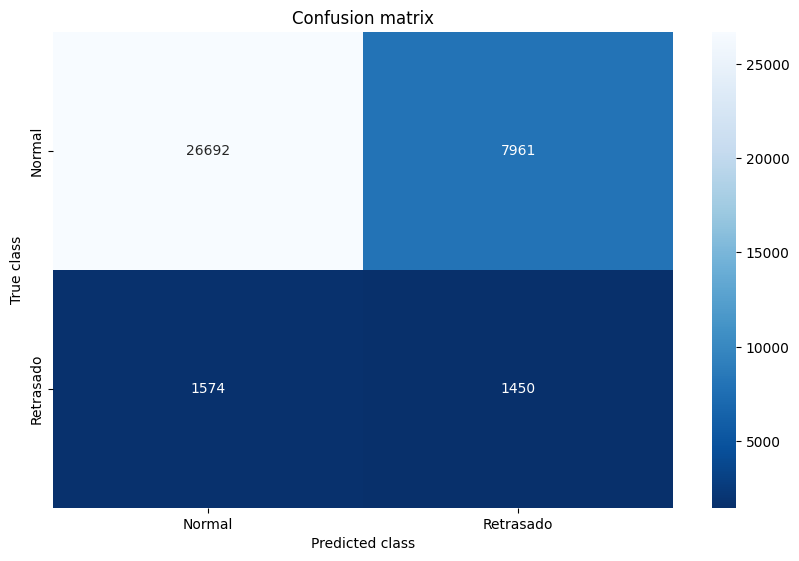

              precision    recall  f1-score   support

           0       0.94      0.77      0.85     34653
           1       0.15      0.48      0.23      3024

    accuracy                           0.75     37677
   macro avg       0.55      0.62      0.54     37677
weighted avg       0.88      0.75      0.80     37677



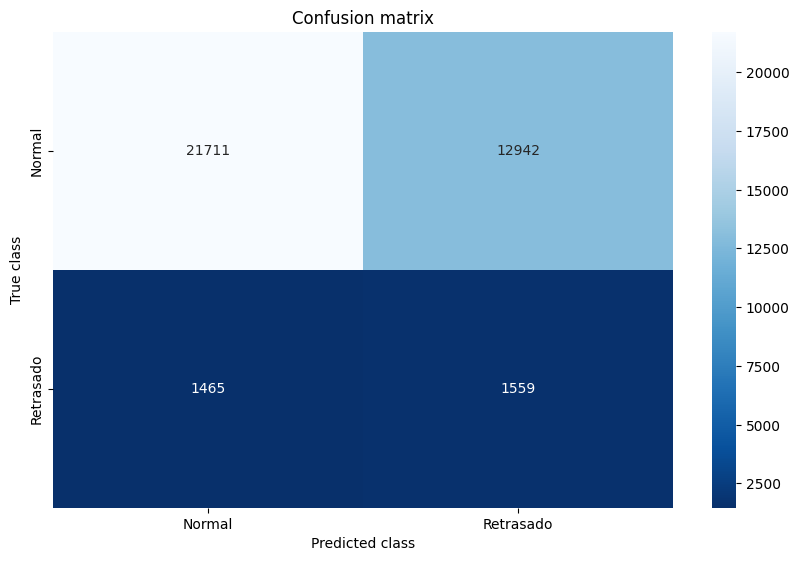

              precision    recall  f1-score   support

           0       0.94      0.63      0.75     34653
           1       0.11      0.52      0.18      3024

    accuracy                           0.62     37677
   macro avg       0.52      0.57      0.46     37677
weighted avg       0.87      0.62      0.70     37677



In [ ]:
#@title Mejores modelos obtenidos sin balance de clases
#lrp = LogisticRegression(C=1.0, penalty='l2', random_state=rs, solver="newton-cg", class_weight="balanced")
run_model(X_train, X_test, y_train, y_test, bbc, True)

run_model(X_train, X_test, y_train, y_test, lrp, True)

#### Análisis con balanceo - **Submuestreo**

In [ ]:
#@title Subsampleo

# Se realiza el análisis sobre los mejores modelos

us = NearMiss(sampling_strategy='auto', n_neighbors=3, version=1) # version=2 se queda sin RAM
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

sampleos(y_train, y_train_res)

trained_subsam = []
correr_modelos(X_train_res, X_test, y_train_res, y_test, models, trained_subsam)
#model = run_model(X_train_res, X_test, y_train_res, y_test, lr, True)
#pred_y = model.predict(X_test)
#mostrar_resultados(y_test, pred_y)

Distribution of class labels before resampling Counter({0: 80655, 1: 7255}) 
Distribution of class labels after resampling Counter({0: 7255, 1: 7255})
---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Regresión Logística ###
Report train
              precision    recall  f1-score   support

           0       0.65      0.82      0.73      7255
           1       0.76      0.56      0.64      7255

    accuracy                           0.69     14510
   macro avg       0.71      0.69      0.68     14510
weighted avg       0.71      0.69      0.68     14510

Report test =============
              precision    recall  f1-score   support

           0       0.92      0.42      0.58     34653
           1       0.08      0.56      0.14      3024

    accuracy                           0.43     37677
   macro avg       0.50      0.49      0.36     37677
weighted avg       0.85      0.43      0.54     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### R

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.63      0.93      0.75      7255
           1       0.87      0.44      0.59      7255

    accuracy                           0.69     14510
   macro avg       0.75      0.69      0.67     14510
weighted avg       0.75      0.69      0.67     14510

Report test =============
              precision    recall  f1-score   support

           0       0.92      0.59      0.72     34653
           1       0.09      0.45      0.14      3024

    accuracy                           0.58     37677
   macro avg       0.51      0.52      0.43     37677
weighted avg       0.86      0.58      0.67     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Balanced Bagging Classifier ###
Report train
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7255
           1       0.97      0.93      0.95      7255

    accuracy                    

Como podemos observar, varios modelos mejoran en recall alcanzando valores por arriba de 0.80, pero en f1 no superan 0.15. El mejor modelo corresponde al Árbol de decisión con 0.85 en recall y 0.14 en f1.

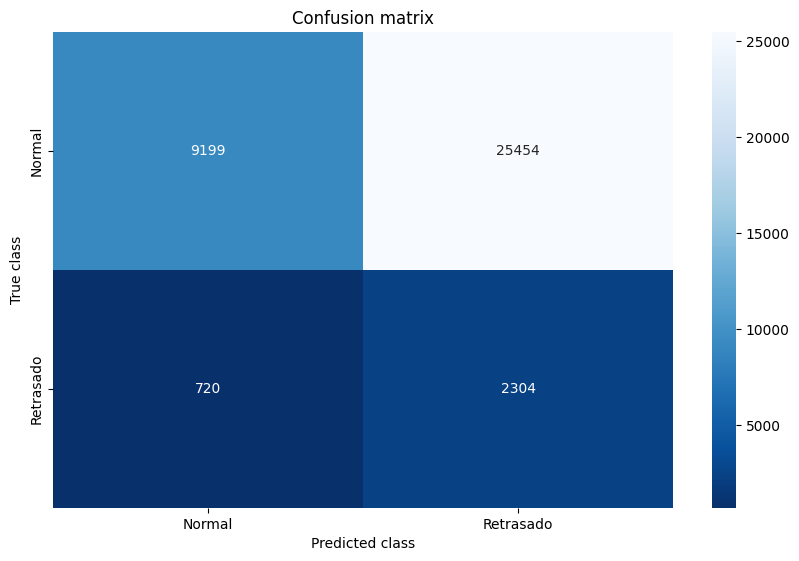

              precision    recall  f1-score   support

           0       0.93      0.27      0.41     34653
           1       0.08      0.76      0.15      3024

    accuracy                           0.31     37677
   macro avg       0.51      0.51      0.28     37677
weighted avg       0.86      0.31      0.39     37677



In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test, dtc, True)

#### Análisis con balanceo - Sobremuestreo

In [ ]:
#@title Oversampling
os =  RandomOverSampler(sampling_strategy='auto')#.5)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

sampleos(y_train, y_train_res)

trained_oversam = []
correr_modelos(X_train_res, X_test, y_train_res, y_test, models, trained_oversam)

#model = run_model(X_train_res, X_test, y_train_res, y_test, gnb, True)
#pred_y = model.predict(X_test)
#mostrar_resultados(y_test, pred_y)


Distribution of class labels before resampling Counter({0: 80655, 1: 7255}) 
Distribution of class labels after resampling Counter({0: 80655, 1: 80655})
---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Regresión Logística ###
Report train
              precision    recall  f1-score   support

           0       0.56      0.63      0.59     80655
           1       0.58      0.51      0.54     80655

    accuracy                           0.57    161310
   macro avg       0.57      0.57      0.57    161310
weighted avg       0.57      0.57      0.57    161310

Report test =============
              precision    recall  f1-score   support

           0       0.94      0.63      0.75     34653
           1       0.11      0.52      0.18      3024

    accuracy                           0.62     37677
   macro avg       0.52      0.57      0.47     37677
weighted avg       0.87      0.62      0.71     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ###

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.53      0.85      0.66     80655
           1       0.63      0.25      0.36     80655

    accuracy                           0.55    161310
   macro avg       0.58      0.55      0.51    161310
weighted avg       0.58      0.55      0.51    161310

Report test =============
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     34653
           1       0.13      0.25      0.17      3024

    accuracy                           0.80     37677
   macro avg       0.53      0.55      0.53     37677
weighted avg       0.86      0.80      0.83     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Balanced Bagging Classifier ###
Report train
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     80655
           1       0.99      1.00      1.00     80655

    accuracy                    

Para el sobremuestreo aleatorio, no hay mejoras significativas, es más, se produce una baja en el recall en general. Tanto el perceptrón multicapa como XGBoost poseen f1 de 0.18 y 0.19 respectivamente, y con recall de 0.40 y 0.45.

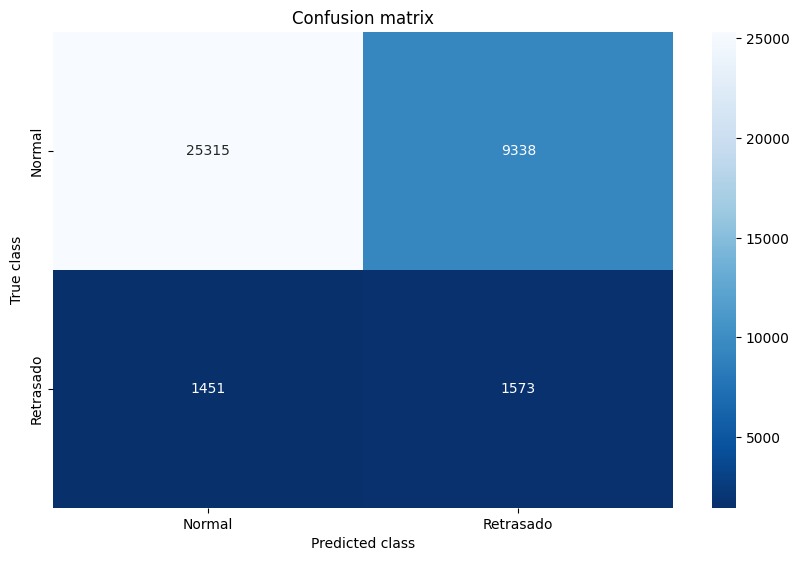

              precision    recall  f1-score   support

           0       0.95      0.73      0.82     34653
           1       0.14      0.52      0.23      3024

    accuracy                           0.71     37677
   macro avg       0.54      0.63      0.53     37677
weighted avg       0.88      0.71      0.78     37677



In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test, xgbc, True)

#### Análisis con balanceo - **Combinado**

In [ ]:
#@title Combinando SMOTE+Tomek
os_us = SMOTETomek(sampling_strategy='auto')
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)

sampleos(y_train, y_train_res)

trained_stomek = []
correr_modelos(X_train_res, X_test, y_train_res, y_test, models, trained_stomek)

#model = run_model(X_train_res, X_test, y_train_res, y_test, lrp, True)
#pred_y = model.predict(X_test)
#mostrar_resultados(y_test, pred_y)

Distribution of class labels before resampling Counter({0: 80655, 1: 7255}) 
Distribution of class labels after resampling Counter({0: 79354, 1: 79354})
---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Regresión Logística ###
Report train
              precision    recall  f1-score   support

           0       0.57      0.61      0.59     79354
           1       0.58      0.53      0.56     79354

    accuracy                           0.57    158708
   macro avg       0.57      0.57      0.57    158708
weighted avg       0.57      0.57      0.57    158708

Report test =============
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     34653
           1       0.11      0.54      0.18      3024

    accuracy                           0.60     37677
   macro avg       0.52      0.57      0.46     37677
weighted avg       0.87      0.60      0.69     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ###

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.66      0.62      0.64     79354
           1       0.64      0.68      0.66     79354

    accuracy                           0.65    158708
   macro avg       0.65      0.65      0.65    158708
weighted avg       0.65      0.65      0.65    158708

Report test =============
              precision    recall  f1-score   support

           0       0.95      0.60      0.74     34653
           1       0.12      0.60      0.20      3024

    accuracy                           0.60     37677
   macro avg       0.53      0.60      0.47     37677
weighted avg       0.88      0.60      0.69     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### XGBoost ###
Report train
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     79354
           1       1.00      0.90      0.95     79354

    accuracy                           0.95    15870

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.58      0.30      0.40     79354
           1       0.53      0.78      0.63     79354

    accuracy                           0.54    158708
   macro avg       0.55      0.54      0.51    158708
weighted avg       0.55      0.54      0.51    158708

Report test =============
              precision    recall  f1-score   support

           0       0.94      0.31      0.46     34653
           1       0.09      0.77      0.16      3024

    accuracy                           0.35     37677
   macro avg       0.51      0.54      0.31     37677
weighted avg       0.87      0.35      0.44     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Balanced Bagging Classifier ###
Report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     79354
           1       1.00      0.99      0.99     79354

    accuracy                    

Al realizar un balanceo combina con SMOTE + Tomek se observa que:

modelo | recall | f1
--- | --- | ---
Perceptrón | 0.60 | 0.20
SVM | 0.77 | 0.16

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


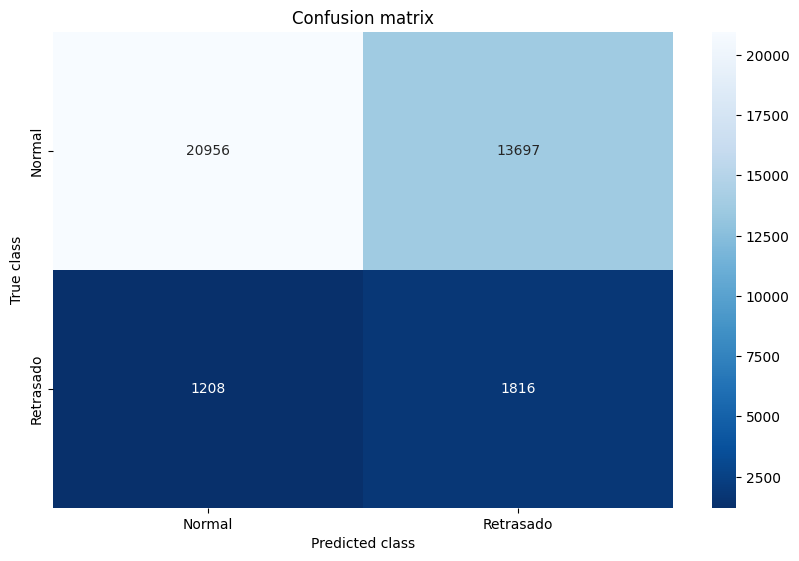

              precision    recall  f1-score   support

           0       0.95      0.60      0.74     34653
           1       0.12      0.60      0.20      3024

    accuracy                           0.60     37677
   macro avg       0.53      0.60      0.47     37677
weighted avg       0.88      0.60      0.69     37677



In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test, mlpc, True)

In [ ]:
#@title Combinación SMOTE NN

smote_enn = SMOTEENN(sampling_strategy='auto')
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

sampleos(y_train, y_train_res)

trained_snn = []
correr_modelos(X_train_res, X_test, y_train_res, y_test, models, trained_snn)


Distribution of class labels before resampling Counter({0: 80655, 1: 7255}) 
Distribution of class labels after resampling Counter({1: 69469, 0: 54589})
---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Regresión Logística ###
Report train
              precision    recall  f1-score   support

           0       0.54      0.35      0.42     54589
           1       0.60      0.77      0.67     69469

    accuracy                           0.58    124058
   macro avg       0.57      0.56      0.55    124058
weighted avg       0.58      0.58      0.56    124058

Report test =============
              precision    recall  f1-score   support

           0       0.94      0.31      0.47     34653
           1       0.09      0.77      0.16      3024

    accuracy                           0.35     37677
   macro avg       0.51      0.54      0.32     37677
weighted avg       0.87      0.35      0.45     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ###

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.67      0.58      0.62     54589
           1       0.70      0.78      0.74     69469

    accuracy                           0.69    124058
   macro avg       0.69      0.68      0.68    124058
weighted avg       0.69      0.69      0.69    124058

Report test =============
              precision    recall  f1-score   support

           0       0.95      0.50      0.65     34653
           1       0.11      0.69      0.19      3024

    accuracy                           0.51     37677
   macro avg       0.53      0.60      0.42     37677
weighted avg       0.88      0.51      0.62     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### XGBoost ###
Report train
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     54589
           1       1.00      0.92      0.96     69469

    accuracy                           0.95    12405

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.55      0.15      0.24     54589
           1       0.58      0.90      0.70     69469

    accuracy                           0.57    124058
   macro avg       0.56      0.53      0.47    124058
weighted avg       0.56      0.57      0.50    124058

Report test =============
              precision    recall  f1-score   support

           0       0.94      0.14      0.24     34653
           1       0.08      0.90      0.15      3024

    accuracy                           0.20     37677
   macro avg       0.51      0.52      0.20     37677
weighted avg       0.87      0.20      0.23     37677


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Balanced Bagging Classifier ###
Report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     54589
           1       1.00      0.99      0.99     69469

    accuracy                    

Al combinar balanceo por SMOTE + NN observamos que:

modelo | recall | f1
--- | --- | ---
Regresión logística | 0.77 | 0.16
Perceptrón | 0.69 | 0.19
SVM | 0.90 | 0.15

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


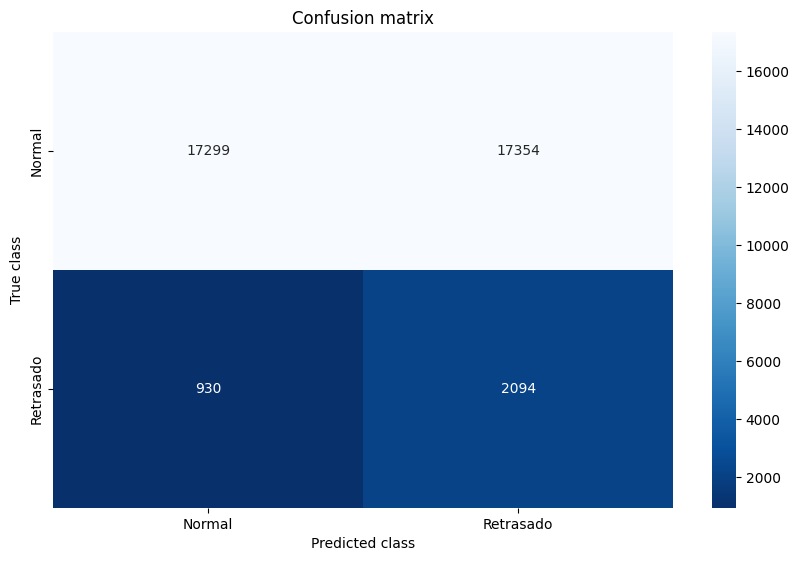

              precision    recall  f1-score   support

           0       0.95      0.50      0.65     34653
           1       0.11      0.69      0.19      3024

    accuracy                           0.51     37677
   macro avg       0.53      0.60      0.42     37677
weighted avg       0.88      0.51      0.62     37677



In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test, mlpc, True)

En general, se pudo mejorar el recall hasta valores superiores a 0.80, pero no se pudo mejorar f1, no se llega al 0.20 con todos los modelos probados.

### Análisis de la DB FILTRADA

Solo corremos los modelos la DB balanceada.

In [ ]:

col2a2 = ['Acft_encoder', 'Dia_Semana_0', 'Dia_Semana_1', 'Dia_Semana_2', 'Dia_Semana_3', 'Dia_Semana_4', 'Dia_Semana_5', 'Dia_Semana_6', 'dist_log_estandar', 'Clima', 'mes_norm', 'hora_norm', 'carga']

y = df2[retraso]

tirar = ret + tds
#X = df2.drop(columns=tirar)
X = df2[col2a2]
# dividimos el set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=perc_div, random_state=rs)
y_train.value_counts(), y_test.value_counts()

(0    59521
 1     4978
 Name: Retraso1, dtype: int64,
 0    25564
 1     2079
 Name: Retraso1, dtype: int64)

In [ ]:
#@title Balanceo los datos de entrenamiento, con función SMOTE que realiza una ampliación de la clase minoritaria
smote = SMOTE(sampling_strategy='auto', random_state=rs)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

sampleos(y_train, y_train_res)

trained_snnf = []
correr_modelos(X_train_res, X_test, y_train_res, y_test, models, trained_snnf)


Distribution of class labels before resampling Counter({0: 59521, 1: 4978}) 
Distribution of class labels after resampling Counter({0: 59521, 1: 59521})
---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Regresión Logística ###
Report train
              precision    recall  f1-score   support

           0       0.54      0.54      0.54     59521
           1       0.54      0.54      0.54     59521

    accuracy                           0.54    119042
   macro avg       0.54      0.54      0.54    119042
weighted avg       0.54      0.54      0.54    119042

Report test =============
              precision    recall  f1-score   support

           0       0.93      0.54      0.68     25564
           1       0.09      0.53      0.15      2079

    accuracy                           0.54     27643
   macro avg       0.51      0.54      0.42     27643
weighted avg       0.87      0.54      0.64     27643


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ###

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.63      0.75      0.69     59521
           1       0.69      0.56      0.62     59521

    accuracy                           0.66    119042
   macro avg       0.66      0.66      0.65    119042
weighted avg       0.66      0.66      0.65    119042

Report test =============
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     25564
           1       0.12      0.41      0.18      2079

    accuracy                           0.72     27643
   macro avg       0.53      0.58      0.51     27643
weighted avg       0.88      0.72      0.78     27643


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### XGBoost ###
Report train
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     59521
           1       1.00      0.90      0.95     59521

    accuracy                           0.95    11904

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Report train
              precision    recall  f1-score   support

           0       0.54      0.58      0.56     59521
           1       0.55      0.51      0.53     59521

    accuracy                           0.54    119042
   macro avg       0.54      0.54      0.54    119042
weighted avg       0.54      0.54      0.54    119042

Report test =============
              precision    recall  f1-score   support

           0       0.93      0.58      0.71     25564
           1       0.09      0.50      0.15      2079

    accuracy                           0.57     27643
   macro avg       0.51      0.54      0.43     27643
weighted avg       0.87      0.57      0.67     27643


---o---o---o---o---o---o---o---o---o---o---o---o---
Training ### Balanced Bagging Classifier ###
Report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     59521
           1       1.00      0.99      0.99     59521

    accuracy                    

No se aprencian cambios significativos al clasificar con la DB filtrada.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


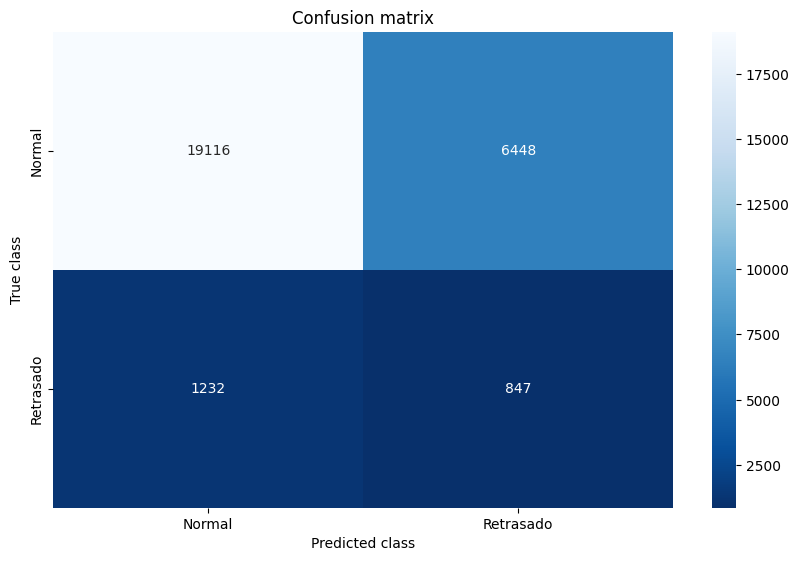

              precision    recall  f1-score   support

           0       0.94      0.75      0.83     25564
           1       0.12      0.41      0.18      2079

    accuracy                           0.72     27643
   macro avg       0.53      0.58      0.51     27643
weighted avg       0.88      0.72      0.78     27643



In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test, mlpc, True)

## Modelo de regresión

Al modelo de regresión le enseñamos con los datos de entrenamiento fltrando solo los vuelos retrasados con el objetivo de que nos devuelva un valor númerico que represente los minutos de retraso

In [ ]:
#columns_regressor = ['Acft_encoder', 'Dia_Semana_0', 'Dia_Semana_1', 'Dia_Semana_2', 'Dia_Semana_3', 'Dia_Semana_4', 'Dia_Semana_5', 'Dia_Semana_6', 'dist_log_estandar']
X_regressor = df2[col2a2]
y_regressor = df2[td_est]
X_regressor_positive = X_regressor[df2[retraso] == 1]
y_regressor_positive = y_regressor[df2[retraso] == 1]

X_train, X_test, y_train, y_test = train_test_split(X_regressor_positive, y_regressor_positive, test_size=perc_div, random_state=rs)

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=rs)
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=1000, random_state=19)

In [ ]:
y_pred = rf_regressor.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred) #error cuadratico medio, mide el promedio de los errores al cuadrado entre la prediccion y el valor real
r2 = r2_score(y_test, y_pred) #Este mide la proporción de variabilidad en la variable objetivo que es explicada por el modelo. va de 0 a 1, 0 no explica ninguna variabilidad
# y un r2 cercano a 1 indica que el modelo es capas de explicar una gran parte de la variabilidad de los datos, esto seria un buen ajuste.

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R-squared): {r2}")

Error cuadrático medio (MSE): 5.866383145649102
Coeficiente de determinación (R-squared): -0.07219332322348193


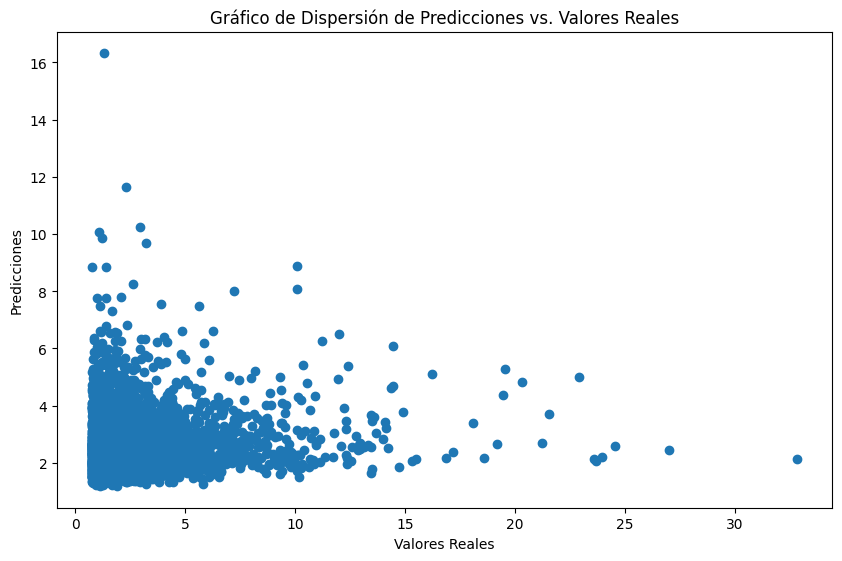

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de Dispersión de Predicciones vs. Valores Reales")
plt.show()

Este modelo esta prediciendo mal. Las metricas son muy malas, y en este grafico lo podemos confirmar, si el modelo se ajustara bien, el grafico se debería parecer a una recta con pendiente de 45º